In [1]:
from collections import defaultdict
import copy
import random
import os
from urllib.request import urlretrieve

import cv2
import matplotlib.pyplot as plt
import numpy as np
import ternausnet.models
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.augmentations.transforms as T
from albumentations.pytorch import ToTensorV2

from segmentation_models_pytorch.losses import DiceLoss 
import segmentation_models_pytorch as smp
import PIL
import glob
import pandas as pd
import time


cudnn.benchmark = True

c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

In [3]:
all_img_paths = glob.glob("data/test/img/*")+glob.glob("data/train/img/*")+glob.glob("data/val/img/*")
correct_images_paths = [i for i in all_img_paths if cv2.imread(i) is not None]

random.seed(33)
random.shuffle(correct_images_paths)

images_paths = {'train' : correct_images_paths[:800],
                'val' : correct_images_paths[800:-50],
                'test' : correct_images_paths[-50:],
                }

for x in ['train', 'val', 'test']:
    print(x+' size: ', len(images_paths[x]))

train size:  800
val size:  230
test size:  50


data/train/img\(0018)aria_d_26.tif
data/train/segm\(0018)aria_d_26.tif


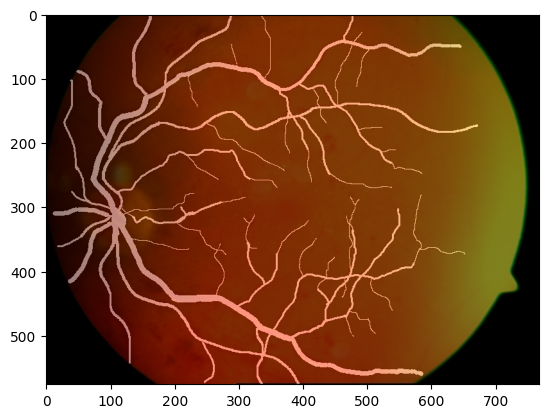

In [4]:
img_xd = images_paths['test'][0]
image = cv2.imread(img_xd)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = PIL.Image.fromarray(image)
mask_path = str(img_xd).replace("/img\\", "/segm\\")
if mask_path.split('\\')[-1][0] !='f' and mask_path.split('\\')[-1].split('.')[-1] == 'jpg':
    mask_path = mask_path.replace('.jpg', '.tif').replace('est', '')
mask = cv2.imread(mask_path)
mask = PIL.Image.fromarray(mask)
print(img_xd)
print(mask_path)
plt.imshow(image)
plt.imshow(mask, alpha=0.5)

In [5]:
def display_image_grid(images_paths, predicted_masks=None, predicted_probabilities=None):
    cols = 3 if predicted_masks else 2
    if predicted_probabilities: cols += 1
    rows = len(images_paths)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i, image_path in enumerate(images_paths):
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask_path = str(image_path).replace("/img\\", "/segm\\")
        if mask_path.split('\\')[-1][0] !='f' and (mask_path.split('\\')[-1].split('.')[-1] == 'jpg' or mask_path.split('\\')[-1].split('.')[-1] == 'JPG'):
            mask_path = mask_path.replace('.jpg', '.tif').replace('.JPG', '.tif')
        mask = plt.imread(mask_path)
        # mask = preprocess_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
        if predicted_probabilities:
            probability = predicted_probabilities[i]
            ax[i, 3].imshow(probability, interpolation="nearest")
            ax[i, 3].set_title("Predicted probability")
            
    plt.tight_layout()
    plt.show()

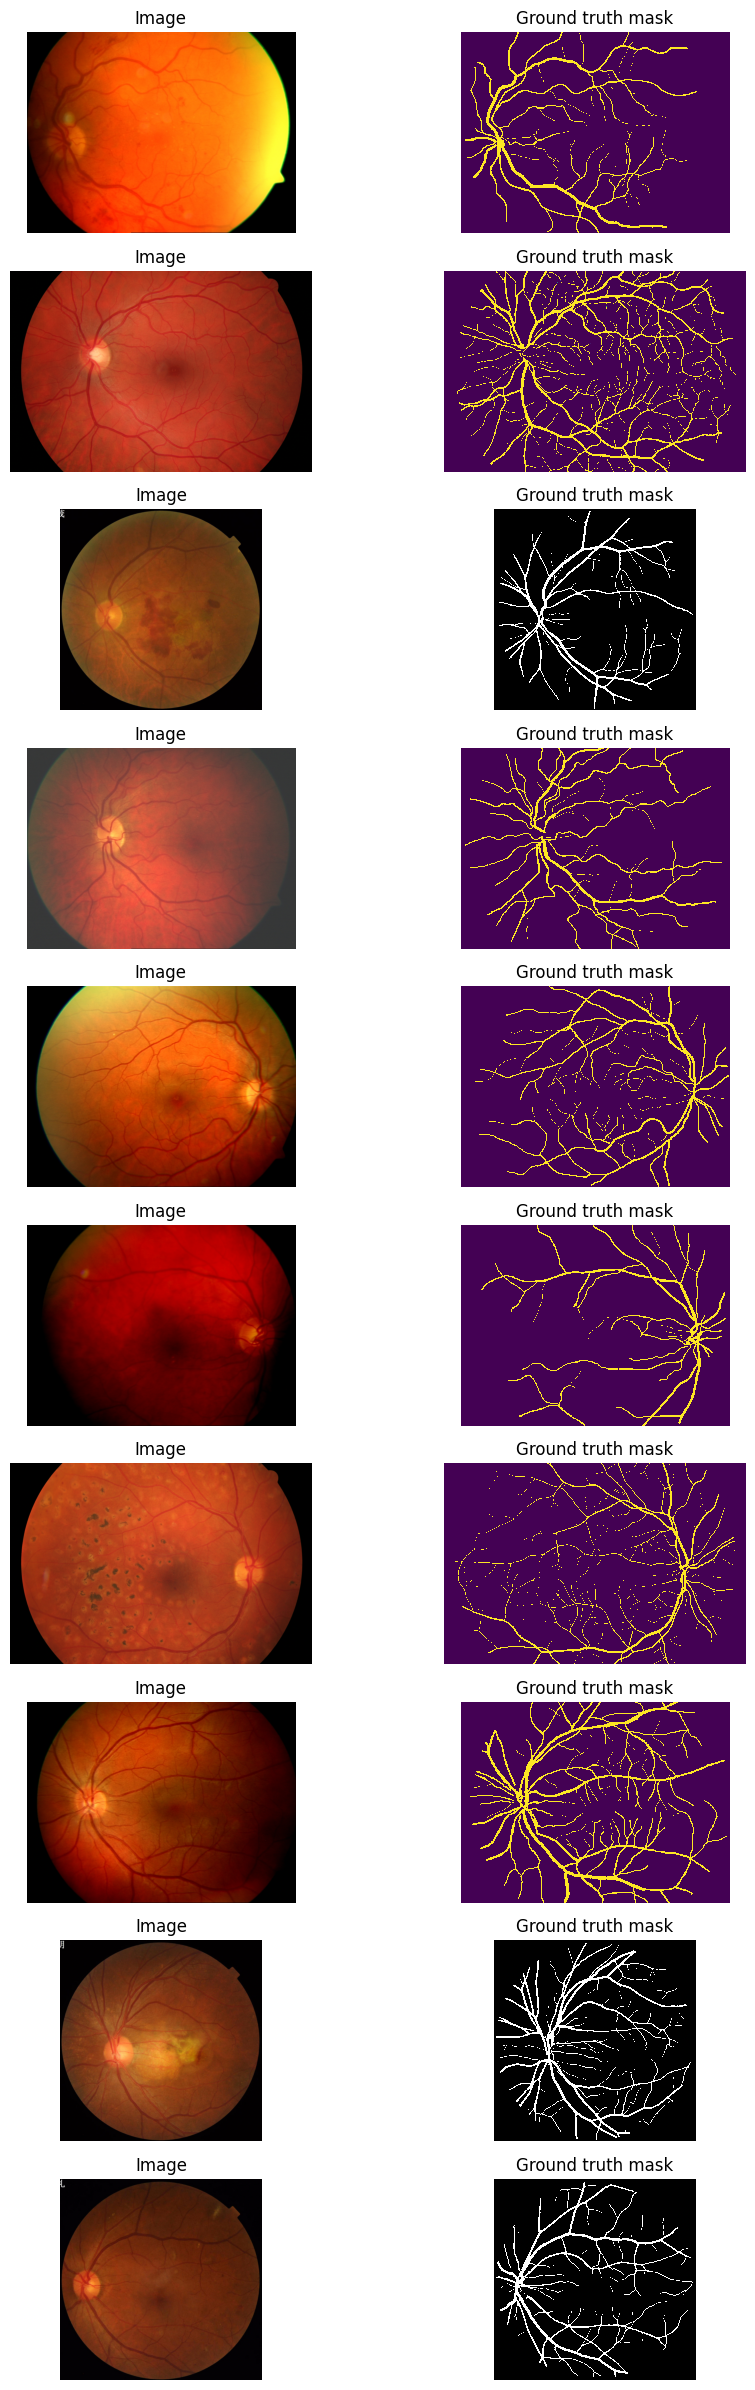

In [6]:
display_image_grid(images_paths['test'][:10])

In [7]:
model_name = "UNet11"
batch_size = 9
epochs_num = 35
img_size = 256
lr = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 255] = 1
    return mask

class SegmDataset(Dataset):
    def __init__(self, images_paths, transform=None):
        self.images_paths = images_paths
        self.transform = transform

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        image_path = self.images_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        original_size = tuple(image.shape[:2])

        mask_path = str(image_path).replace("/img\\", "/segm\\")
        if mask_path.split('\\')[-1][0] !='f' and (mask_path.split('\\')[-1].split('.')[-1] == 'jpg' or mask_path.split('\\')[-1].split('.')[-1] == 'JPG'):
            mask_path = mask_path.replace('.jpg', '.tif').replace('.JPG', '.tif')
        mask = plt.imread(mask_path)
        mask = preprocess_mask(mask)        
        
        
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        if len(mask.shape) == 3:
            mask=mask[:,:, 0]
        return image, mask, original_size


data_transforms = {
    'train': A.Compose([
        A.Resize(img_size,img_size),
        T.ColorJitter(brightness=0.2, contrast=0.2, hue=(-0.025,0.025)),
        T.Normalize([0.3998, 0.1676, 0.0636], [0.2762, 0.1356, 0.0666]),
        ToTensorV2()
        ]),
    'val': A.Compose([
        A.Resize(img_size,img_size),
        T.Normalize([0.3998, 0.1676, 0.0636], [0.2762, 0.1356, 0.0666]),
        ToTensorV2()
        ]),
    'test': A.Compose([
        A.Resize(img_size,img_size),
        T.Normalize([0.3998, 0.1676, 0.0636], [0.2762, 0.1356, 0.0666]),
        ToTensorV2()
        ])
}

datasets = {x: SegmDataset(images_paths[x], transform=data_transforms[x],) for x in ['train', 'val', 'test']}
loaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True,) for x in ['train', 'val']}
loaders['test'] = DataLoader(datasets['test'], batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True,)

nm_model = f'models/{model_name}_e{epochs_num}_s{img_size}_b{batch_size}_jit'

In [11]:
def visualize_augmentations(dataset, idx=0, samples=2):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (T.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=3, figsize=(10, 8))
    for i in range(samples):
        image, mask, _ = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 2].imshow(image)
        ax[i, 2].imshow(mask, interpolation="nearest", alpha=0.5)
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 2].set_title("Blend")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

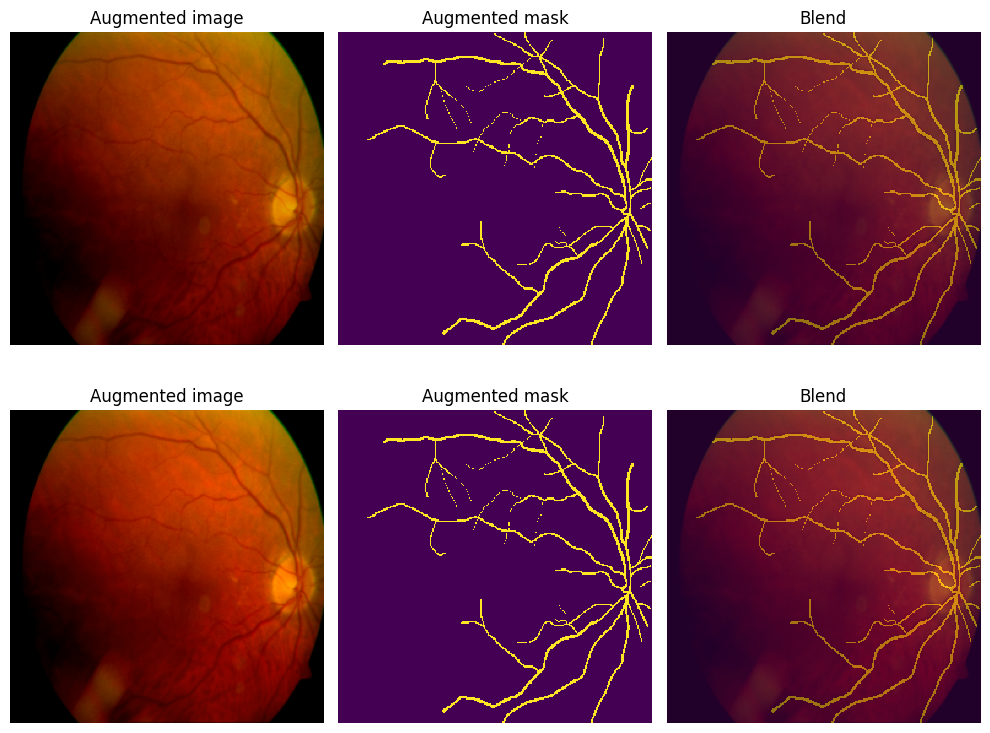

In [12]:
random.seed(42)
visualize_augmentations(datasets['train'], idx=55)

In [13]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [14]:
def create_model(model_name, device):
    model = getattr(ternausnet.models, model_name)(pretrained=True)
    model = model.to(device)
    return model

model = create_model(model_name, device)
# criterion = nn.BCEWithLogitsLoss().to(device)
criterion = DiceLoss(mode='binary').to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
def train_and_validate(model, criterion, optimizer, epochs_num=25):
    since = time.time()

    model_data = pd.DataFrame({'epoch number': [],
                               'train loss': [],
                               'validation loss': [],
                               'train iou_score': [],
                               'validation iou_score': [],
                               'train f1_score': [],
                               'validation f1_score': [],
                               'train f2_score': [],
                               'validation f2_score': [],
                               'train accuracy': [],
                               'validation accuracy': [],
                               'train recall': [],
                               'validation recall': [],
                               'train precision': [],
                               'validation precision': [],
                               'train specificity': [],
                               'validation specificity': [],
                               'test loss':[],
                               'test iou_score':[],
                               'test f1_score':[],
                               'test f2_score':[],
                               'test accuracy':[],
                               'test recall':[],
                               'test precision':[],
                               'test specificity':[]})
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    for epoch in range(epochs_num):

        print(f'Epoch [{epoch+1}/{epochs_num}]')
        model_data.at[epoch, 'epoch number'] = epoch+1

        for phase in ['train', 'val']:
            
            metric_monitor = MetricMonitor()

            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            stream = tqdm(loaders[phase])
            for i, (images, target, _) in enumerate(stream, start=1):
                images = images.to(device, non_blocking=True)
                target = target.to(device, non_blocking=True)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    output = model(images).squeeze(1)

                    tp, fp, fn, tn = smp.metrics.get_stats(output, target.type(torch.int), mode='binary', threshold=0.5)
                    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
                    f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro-imagewise")
                    f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro-imagewise")
                    accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro-imagewise")
                    recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
                    precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro-imagewise")
                    specificity = smp.metrics.specificity(tp, fp, fn, tn, reduction="micro-imagewise")

                    loss = criterion(output, target)

                    metric_monitor.update("Loss", loss.item())

                    metric_monitor.update("iou score", iou_score.item())
                    metric_monitor.update("f1 score", f1_score.item())
                    metric_monitor.update("f2 score", f2_score.item())
                    metric_monitor.update("accuracy", accuracy.item())
                    metric_monitor.update("recall", recall.item())
                    metric_monitor.update("precision", precision.item())
                    metric_monitor.update("specificity", specificity.item())

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                stream.set_description(
                    "{phase}: {metric_monitor}".format(phase=phase, metric_monitor=metric_monitor)
                )
                torch.cuda.empty_cache()
            
            epoch_f1 = metric_monitor.metrics['f1 score']['avg']

            if phase == 'train':
                model_data.at[epoch, 'train loss'] = metric_monitor.metrics['Loss']['avg']
                model_data.at[epoch, 'train iou score'] = metric_monitor.metrics['iou score']['avg']
                model_data.at[epoch, 'train f1 score'] = metric_monitor.metrics['f1 score']['avg']
                model_data.at[epoch, 'train f2 score'] = metric_monitor.metrics['f2 score']['avg']
                model_data.at[epoch, 'train accuracy'] = metric_monitor.metrics['accuracy']['avg']
                model_data.at[epoch, 'train recall'] = metric_monitor.metrics['recall']['avg']
                model_data.at[epoch, 'train precision'] = metric_monitor.metrics['precision']['avg']
                model_data.at[epoch, 'train specificity'] = metric_monitor.metrics['specificity']['avg']
            else:
                model_data.at[epoch, 'validation loss'] = metric_monitor.metrics['Loss']['avg']
                model_data.at[epoch, 'validation iou score'] = metric_monitor.metrics['iou score']['avg']
                model_data.at[epoch, 'validation f1 score'] = metric_monitor.metrics['f1 score']['avg']
                model_data.at[epoch, 'validation f2 score'] = metric_monitor.metrics['f2 score']['avg']
                model_data.at[epoch, 'validation accuracy'] = metric_monitor.metrics['accuracy']['avg']
                model_data.at[epoch, 'validation recall'] = metric_monitor.metrics['recall']['avg']
                model_data.at[epoch, 'validation precision'] = metric_monitor.metrics['precision']['avg']
                model_data.at[epoch, 'validation specificity'] = metric_monitor.metrics['specificity']['avg']
            
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    model.load_state_dict(best_model_wts)
    model_data.to_csv(nm_model+'_stats.csv', index=False)

    return model

In [16]:
model = train_and_validate(model, criterion, optimizer, epochs_num)

Epoch [1/35]


train: Loss: 0.431 | iou score: 0.398 | f1 score: 0.549 | f2 score: 0.560 | accuracy: 0.913 | recall: 0.603 | precision: 0.619 | specificity: 0.936: 100%|██████████| 89/89 [02:50<00:00,  1.92s/it]
val: Loss: 0.386 | iou score: 0.474 | f1 score: 0.634 | f2 score: 0.717 | accuracy: 0.933 | recall: 0.798 | precision: 0.543 | specificity: 0.943: 100%|██████████| 26/26 [00:27<00:00,  1.08s/it]


Epoch [2/35]


train: Loss: 0.298 | iou score: 0.523 | f1 score: 0.678 | f2 score: 0.669 | accuracy: 0.955 | recall: 0.670 | precision: 0.724 | specificity: 0.977: 100%|██████████| 89/89 [02:09<00:00,  1.46s/it]
val: Loss: 0.294 | iou score: 0.538 | f1 score: 0.690 | f2 score: 0.674 | accuracy: 0.959 | recall: 0.669 | precision: 0.749 | specificity: 0.980: 100%|██████████| 26/26 [00:22<00:00,  1.15it/s]


Epoch [3/35]


train: Loss: 0.276 | iou score: 0.542 | f1 score: 0.695 | f2 score: 0.691 | accuracy: 0.956 | recall: 0.699 | precision: 0.729 | specificity: 0.975: 100%|██████████| 89/89 [02:05<00:00,  1.41s/it]
val: Loss: 0.275 | iou score: 0.562 | f1 score: 0.711 | f2 score: 0.694 | accuracy: 0.961 | recall: 0.686 | precision: 0.763 | specificity: 0.981: 100%|██████████| 26/26 [00:21<00:00,  1.19it/s]


Epoch [4/35]


train: Loss: 0.244 | iou score: 0.580 | f1 score: 0.727 | f2 score: 0.721 | accuracy: 0.961 | recall: 0.724 | precision: 0.754 | specificity: 0.979: 100%|██████████| 89/89 [02:02<00:00,  1.38s/it]
val: Loss: 0.250 | iou score: 0.597 | f1 score: 0.740 | f2 score: 0.750 | accuracy: 0.963 | recall: 0.760 | precision: 0.734 | specificity: 0.977: 100%|██████████| 26/26 [00:21<00:00,  1.19it/s]


Epoch [5/35]


train: Loss: 0.234 | iou score: 0.599 | f1 score: 0.742 | f2 score: 0.737 | accuracy: 0.963 | recall: 0.740 | precision: 0.766 | specificity: 0.980: 100%|██████████| 89/89 [02:02<00:00,  1.37s/it]
val: Loss: 0.258 | iou score: 0.582 | f1 score: 0.727 | f2 score: 0.711 | accuracy: 0.963 | recall: 0.704 | precision: 0.772 | specificity: 0.982: 100%|██████████| 26/26 [00:21<00:00,  1.19it/s]


Epoch [6/35]


train: Loss: 0.226 | iou score: 0.603 | f1 score: 0.746 | f2 score: 0.744 | accuracy: 0.963 | recall: 0.748 | precision: 0.763 | specificity: 0.980: 100%|██████████| 89/89 [02:02<00:00,  1.37s/it]
val: Loss: 0.255 | iou score: 0.591 | f1 score: 0.735 | f2 score: 0.747 | accuracy: 0.961 | recall: 0.759 | precision: 0.733 | specificity: 0.976: 100%|██████████| 26/26 [00:22<00:00,  1.17it/s]


Epoch [7/35]


train: Loss: 0.216 | iou score: 0.613 | f1 score: 0.754 | f2 score: 0.749 | accuracy: 0.965 | recall: 0.750 | precision: 0.775 | specificity: 0.981: 100%|██████████| 89/89 [02:03<00:00,  1.39s/it]
val: Loss: 0.233 | iou score: 0.618 | f1 score: 0.755 | f2 score: 0.742 | accuracy: 0.967 | recall: 0.735 | precision: 0.792 | specificity: 0.984: 100%|██████████| 26/26 [00:21<00:00,  1.19it/s]


Epoch [8/35]


train: Loss: 0.205 | iou score: 0.627 | f1 score: 0.763 | f2 score: 0.759 | accuracy: 0.966 | recall: 0.761 | precision: 0.782 | specificity: 0.982: 100%|██████████| 89/89 [02:04<00:00,  1.39s/it]
val: Loss: 0.232 | iou score: 0.623 | f1 score: 0.759 | f2 score: 0.758 | accuracy: 0.966 | recall: 0.761 | precision: 0.770 | specificity: 0.981: 100%|██████████| 26/26 [00:22<00:00,  1.14it/s]


Epoch [9/35]


train: Loss: 0.201 | iou score: 0.634 | f1 score: 0.769 | f2 score: 0.765 | accuracy: 0.967 | recall: 0.767 | precision: 0.785 | specificity: 0.982: 100%|██████████| 89/89 [02:05<00:00,  1.41s/it]
val: Loss: 0.243 | iou score: 0.613 | f1 score: 0.752 | f2 score: 0.799 | accuracy: 0.961 | recall: 0.837 | precision: 0.692 | specificity: 0.970: 100%|██████████| 26/26 [00:21<00:00,  1.20it/s]


Epoch [10/35]


train: Loss: 0.203 | iou score: 0.633 | f1 score: 0.769 | f2 score: 0.765 | accuracy: 0.967 | recall: 0.766 | precision: 0.786 | specificity: 0.982: 100%|██████████| 89/89 [02:07<00:00,  1.43s/it]
val: Loss: 0.221 | iou score: 0.636 | f1 score: 0.768 | f2 score: 0.763 | accuracy: 0.968 | recall: 0.761 | precision: 0.789 | specificity: 0.983: 100%|██████████| 26/26 [00:21<00:00,  1.20it/s]


Epoch [11/35]


train: Loss: 0.202 | iou score: 0.631 | f1 score: 0.766 | f2 score: 0.763 | accuracy: 0.967 | recall: 0.766 | precision: 0.783 | specificity: 0.982: 100%|██████████| 89/89 [02:01<00:00,  1.37s/it]
val: Loss: 0.231 | iou score: 0.625 | f1 score: 0.760 | f2 score: 0.776 | accuracy: 0.965 | recall: 0.790 | precision: 0.743 | specificity: 0.978: 100%|██████████| 26/26 [00:21<00:00,  1.19it/s]


Epoch [12/35]


train: Loss: 0.197 | iou score: 0.647 | f1 score: 0.778 | f2 score: 0.773 | accuracy: 0.969 | recall: 0.774 | precision: 0.795 | specificity: 0.984: 100%|██████████| 89/89 [02:02<00:00,  1.37s/it]
val: Loss: 0.218 | iou score: 0.643 | f1 score: 0.774 | f2 score: 0.783 | accuracy: 0.968 | recall: 0.792 | precision: 0.766 | specificity: 0.980: 100%|██████████| 26/26 [00:21<00:00,  1.20it/s]


Epoch [13/35]


train: Loss: 0.189 | iou score: 0.648 | f1 score: 0.780 | f2 score: 0.776 | accuracy: 0.968 | recall: 0.779 | precision: 0.793 | specificity: 0.983: 100%|██████████| 89/89 [02:01<00:00,  1.37s/it]
val: Loss: 0.221 | iou score: 0.635 | f1 score: 0.768 | f2 score: 0.767 | accuracy: 0.968 | recall: 0.770 | precision: 0.781 | specificity: 0.982: 100%|██████████| 26/26 [00:21<00:00,  1.21it/s]


Epoch [14/35]


train: Loss: 0.185 | iou score: 0.653 | f1 score: 0.783 | f2 score: 0.778 | accuracy: 0.969 | recall: 0.777 | precision: 0.801 | specificity: 0.984: 100%|██████████| 89/89 [02:01<00:00,  1.37s/it]
val: Loss: 0.216 | iou score: 0.645 | f1 score: 0.776 | f2 score: 0.787 | accuracy: 0.968 | recall: 0.796 | precision: 0.765 | specificity: 0.980: 100%|██████████| 26/26 [00:21<00:00,  1.20it/s]


Epoch [15/35]


train: Loss: 0.179 | iou score: 0.662 | f1 score: 0.791 | f2 score: 0.786 | accuracy: 0.970 | recall: 0.785 | precision: 0.804 | specificity: 0.984: 100%|██████████| 89/89 [02:01<00:00,  1.37s/it]
val: Loss: 0.213 | iou score: 0.649 | f1 score: 0.778 | f2 score: 0.785 | accuracy: 0.968 | recall: 0.792 | precision: 0.774 | specificity: 0.981: 100%|██████████| 26/26 [00:21<00:00,  1.20it/s]


Epoch [16/35]


train: Loss: 0.184 | iou score: 0.656 | f1 score: 0.786 | f2 score: 0.783 | accuracy: 0.969 | recall: 0.783 | precision: 0.800 | specificity: 0.983: 100%|██████████| 89/89 [02:01<00:00,  1.36s/it]
val: Loss: 0.230 | iou score: 0.623 | f1 score: 0.759 | f2 score: 0.745 | accuracy: 0.967 | recall: 0.739 | precision: 0.798 | specificity: 0.984: 100%|██████████| 26/26 [00:21<00:00,  1.21it/s]


Epoch [17/35]


train: Loss: 0.179 | iou score: 0.659 | f1 score: 0.787 | f2 score: 0.782 | accuracy: 0.970 | recall: 0.782 | precision: 0.803 | specificity: 0.984: 100%|██████████| 89/89 [02:01<00:00,  1.36s/it]
val: Loss: 0.215 | iou score: 0.645 | f1 score: 0.775 | f2 score: 0.775 | accuracy: 0.969 | recall: 0.777 | precision: 0.783 | specificity: 0.983: 100%|██████████| 26/26 [00:21<00:00,  1.21it/s]


Epoch [18/35]


train: Loss: 0.181 | iou score: 0.658 | f1 score: 0.787 | f2 score: 0.783 | accuracy: 0.969 | recall: 0.783 | precision: 0.801 | specificity: 0.984: 100%|██████████| 89/89 [02:01<00:00,  1.36s/it]
val: Loss: 0.217 | iou score: 0.641 | f1 score: 0.771 | f2 score: 0.767 | accuracy: 0.969 | recall: 0.765 | precision: 0.789 | specificity: 0.983: 100%|██████████| 26/26 [00:21<00:00,  1.21it/s]


Epoch [19/35]


train: Loss: 0.179 | iou score: 0.660 | f1 score: 0.789 | f2 score: 0.784 | accuracy: 0.970 | recall: 0.782 | precision: 0.804 | specificity: 0.984: 100%|██████████| 89/89 [02:01<00:00,  1.37s/it]
val: Loss: 0.212 | iou score: 0.648 | f1 score: 0.777 | f2 score: 0.778 | accuracy: 0.969 | recall: 0.782 | precision: 0.781 | specificity: 0.983: 100%|██████████| 26/26 [00:21<00:00,  1.21it/s]


Epoch [20/35]


train: Loss: 0.173 | iou score: 0.668 | f1 score: 0.794 | f2 score: 0.788 | accuracy: 0.971 | recall: 0.786 | precision: 0.810 | specificity: 0.985: 100%|██████████| 89/89 [02:01<00:00,  1.37s/it]
val: Loss: 0.208 | iou score: 0.654 | f1 score: 0.781 | f2 score: 0.770 | accuracy: 0.970 | recall: 0.765 | precision: 0.810 | specificity: 0.985: 100%|██████████| 26/26 [00:21<00:00,  1.21it/s]


Epoch [21/35]


train: Loss: 0.168 | iou score: 0.673 | f1 score: 0.798 | f2 score: 0.792 | accuracy: 0.971 | recall: 0.791 | precision: 0.813 | specificity: 0.985: 100%|██████████| 89/89 [02:01<00:00,  1.36s/it]
val: Loss: 0.207 | iou score: 0.657 | f1 score: 0.784 | f2 score: 0.789 | accuracy: 0.969 | recall: 0.795 | precision: 0.783 | specificity: 0.982: 100%|██████████| 26/26 [00:21<00:00,  1.21it/s]


Epoch [22/35]


train: Loss: 0.168 | iou score: 0.677 | f1 score: 0.801 | f2 score: 0.797 | accuracy: 0.971 | recall: 0.795 | precision: 0.815 | specificity: 0.985: 100%|██████████| 89/89 [02:01<00:00,  1.36s/it]
val: Loss: 0.213 | iou score: 0.648 | f1 score: 0.778 | f2 score: 0.793 | accuracy: 0.968 | recall: 0.806 | precision: 0.760 | specificity: 0.980: 100%|██████████| 26/26 [00:21<00:00,  1.21it/s]


Epoch [23/35]


train: Loss: 0.166 | iou score: 0.677 | f1 score: 0.800 | f2 score: 0.795 | accuracy: 0.972 | recall: 0.796 | precision: 0.814 | specificity: 0.985: 100%|██████████| 89/89 [02:01<00:00,  1.37s/it]
val: Loss: 0.222 | iou score: 0.634 | f1 score: 0.766 | f2 score: 0.747 | accuracy: 0.969 | recall: 0.736 | precision: 0.811 | specificity: 0.986: 100%|██████████| 26/26 [00:21<00:00,  1.21it/s]


Epoch [24/35]


train: Loss: 0.167 | iou score: 0.674 | f1 score: 0.798 | f2 score: 0.793 | accuracy: 0.971 | recall: 0.793 | precision: 0.813 | specificity: 0.985: 100%|██████████| 89/89 [02:01<00:00,  1.36s/it]
val: Loss: 0.208 | iou score: 0.657 | f1 score: 0.783 | f2 score: 0.797 | accuracy: 0.969 | recall: 0.809 | precision: 0.768 | specificity: 0.981: 100%|██████████| 26/26 [00:21<00:00,  1.21it/s]


Epoch [25/35]


train: Loss: 0.161 | iou score: 0.682 | f1 score: 0.805 | f2 score: 0.798 | accuracy: 0.972 | recall: 0.797 | precision: 0.820 | specificity: 0.986: 100%|██████████| 89/89 [02:01<00:00,  1.37s/it]
val: Loss: 0.209 | iou score: 0.656 | f1 score: 0.783 | f2 score: 0.792 | accuracy: 0.969 | recall: 0.801 | precision: 0.775 | specificity: 0.981: 100%|██████████| 26/26 [00:21<00:00,  1.20it/s]


Epoch [26/35]


train: Loss: 0.161 | iou score: 0.683 | f1 score: 0.805 | f2 score: 0.799 | accuracy: 0.972 | recall: 0.798 | precision: 0.820 | specificity: 0.985: 100%|██████████| 89/89 [02:01<00:00,  1.37s/it]
val: Loss: 0.208 | iou score: 0.657 | f1 score: 0.783 | f2 score: 0.782 | accuracy: 0.970 | recall: 0.783 | precision: 0.793 | specificity: 0.984: 100%|██████████| 26/26 [00:21<00:00,  1.21it/s]


Epoch [27/35]


train: Loss: 0.161 | iou score: 0.684 | f1 score: 0.806 | f2 score: 0.801 | accuracy: 0.972 | recall: 0.800 | precision: 0.819 | specificity: 0.985: 100%|██████████| 89/89 [02:01<00:00,  1.36s/it]
val: Loss: 0.210 | iou score: 0.652 | f1 score: 0.779 | f2 score: 0.778 | accuracy: 0.969 | recall: 0.780 | precision: 0.790 | specificity: 0.983: 100%|██████████| 26/26 [00:21<00:00,  1.21it/s]


Epoch [28/35]


train: Loss: 0.166 | iou score: 0.675 | f1 score: 0.799 | f2 score: 0.795 | accuracy: 0.971 | recall: 0.794 | precision: 0.813 | specificity: 0.985: 100%|██████████| 89/89 [02:01<00:00,  1.37s/it]
val: Loss: 0.207 | iou score: 0.658 | f1 score: 0.784 | f2 score: 0.784 | accuracy: 0.970 | recall: 0.787 | precision: 0.793 | specificity: 0.983: 100%|██████████| 26/26 [00:21<00:00,  1.19it/s]


Epoch [29/35]


train: Loss: 0.160 | iou score: 0.683 | f1 score: 0.805 | f2 score: 0.800 | accuracy: 0.972 | recall: 0.798 | precision: 0.820 | specificity: 0.986: 100%|██████████| 89/89 [02:01<00:00,  1.37s/it]
val: Loss: 0.204 | iou score: 0.661 | f1 score: 0.786 | f2 score: 0.792 | accuracy: 0.970 | recall: 0.798 | precision: 0.784 | specificity: 0.983: 100%|██████████| 26/26 [00:21<00:00,  1.21it/s]


Epoch [30/35]


train: Loss: 0.155 | iou score: 0.690 | f1 score: 0.810 | f2 score: 0.804 | accuracy: 0.973 | recall: 0.802 | precision: 0.826 | specificity: 0.986: 100%|██████████| 89/89 [02:01<00:00,  1.36s/it]
val: Loss: 0.205 | iou score: 0.661 | f1 score: 0.786 | f2 score: 0.780 | accuracy: 0.970 | recall: 0.779 | precision: 0.805 | specificity: 0.985: 100%|██████████| 26/26 [00:21<00:00,  1.21it/s]


Epoch [31/35]


train: Loss: 0.153 | iou score: 0.693 | f1 score: 0.812 | f2 score: 0.806 | accuracy: 0.973 | recall: 0.805 | precision: 0.826 | specificity: 0.986: 100%|██████████| 89/89 [02:01<00:00,  1.36s/it]
val: Loss: 0.218 | iou score: 0.637 | f1 score: 0.768 | f2 score: 0.768 | accuracy: 0.968 | recall: 0.770 | precision: 0.778 | specificity: 0.982: 100%|██████████| 26/26 [00:21<00:00,  1.21it/s]


Epoch [32/35]


train: Loss: 0.163 | iou score: 0.678 | f1 score: 0.802 | f2 score: 0.796 | accuracy: 0.972 | recall: 0.794 | precision: 0.817 | specificity: 0.985: 100%|██████████| 89/89 [02:01<00:00,  1.37s/it]
val: Loss: 0.205 | iou score: 0.659 | f1 score: 0.785 | f2 score: 0.789 | accuracy: 0.970 | recall: 0.795 | precision: 0.785 | specificity: 0.983: 100%|██████████| 26/26 [00:21<00:00,  1.20it/s]


Epoch [33/35]


train: Loss: 0.156 | iou score: 0.687 | f1 score: 0.808 | f2 score: 0.802 | accuracy: 0.973 | recall: 0.802 | precision: 0.822 | specificity: 0.986: 100%|██████████| 89/89 [02:01<00:00,  1.37s/it]
val: Loss: 0.204 | iou score: 0.659 | f1 score: 0.785 | f2 score: 0.800 | accuracy: 0.969 | recall: 0.813 | precision: 0.768 | specificity: 0.980: 100%|██████████| 26/26 [00:21<00:00,  1.20it/s]


Epoch [34/35]


train: Loss: 0.150 | iou score: 0.700 | f1 score: 0.817 | f2 score: 0.811 | accuracy: 0.974 | recall: 0.808 | precision: 0.832 | specificity: 0.987: 100%|██████████| 89/89 [02:01<00:00,  1.37s/it]
val: Loss: 0.204 | iou score: 0.659 | f1 score: 0.785 | f2 score: 0.785 | accuracy: 0.970 | recall: 0.787 | precision: 0.793 | specificity: 0.984: 100%|██████████| 26/26 [00:21<00:00,  1.21it/s]


Epoch [35/35]


train: Loss: 0.148 | iou score: 0.697 | f1 score: 0.815 | f2 score: 0.808 | accuracy: 0.974 | recall: 0.807 | precision: 0.830 | specificity: 0.987: 100%|██████████| 89/89 [02:01<00:00,  1.37s/it]
val: Loss: 0.203 | iou score: 0.663 | f1 score: 0.788 | f2 score: 0.793 | accuracy: 0.970 | recall: 0.800 | precision: 0.787 | specificity: 0.983: 100%|██████████| 26/26 [00:21<00:00,  1.19it/s]

Training complete in 84m 60s


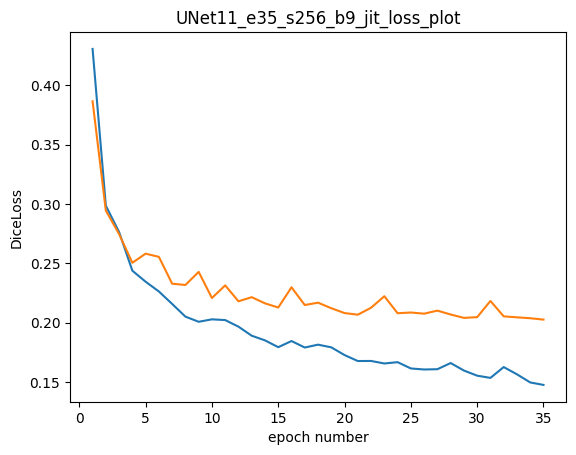

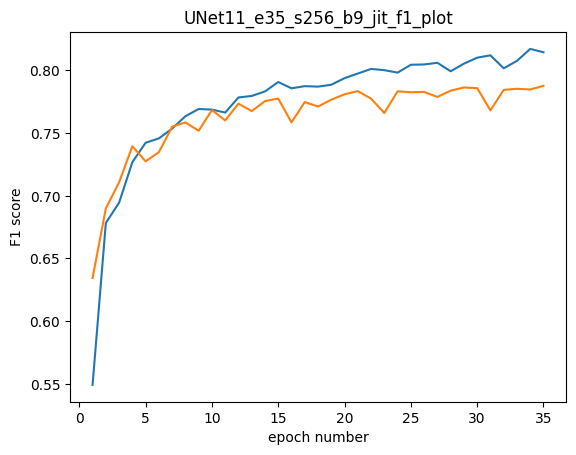

In [17]:
df = pd.read_csv(nm_model+'_stats.csv')

plt.plot(df['epoch number'],df['train loss'])
plt.plot(df['epoch number'],df['validation loss'])
plt.title(nm_model.split('/')[-1]+'_loss_plot')
plt.ylabel('DiceLoss')
plt.xlabel('epoch number')
plt.savefig(nm_model+'_loss_plot.jpg')
plt.show()
plt.plot(df['epoch number'],df['train f1 score'])
plt.plot(df['epoch number'],df['validation f1 score'])
plt.title(nm_model.split('/')[-1]+'_f1_plot')
plt.ylabel('F1 score')
plt.xlabel('epoch number')
plt.savefig(nm_model+'_f1_plot.jpg')
plt.show()

In [18]:
def predict(model):
    phase = 'test'
    model.eval()
    predictions = []
    metric_monitor = MetricMonitor()
    stream = tqdm(loaders[phase])
    with torch.no_grad():
        for i, (images, target, (original_heights, original_widths)) in enumerate(stream, start=1):
            images = images.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            output = model(images).squeeze(1)

            loss = criterion(output, target)
            tp, fp, fn, tn = smp.metrics.get_stats(output, target.type(torch.int), mode='binary', threshold=0.5)
            iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
            f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro-imagewise")
            f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro-imagewise")
            accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro-imagewise")
            recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
            precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro-imagewise")
            specificity = smp.metrics.specificity(tp, fp, fn, tn, reduction="micro-imagewise")

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("iou score", iou_score.item())
            metric_monitor.update("f1 score", f1_score.item())
            metric_monitor.update("f2 score", f2_score.item())
            metric_monitor.update("accuracy", accuracy.item())
            metric_monitor.update("recall", recall.item())
            metric_monitor.update("precision", precision.item())
            metric_monitor.update("specificity", specificity.item())

            probabilities = torch.sigmoid(output.squeeze(1))
            predicted_masks = (probabilities >= 0.5).float() * 1
            probabilities = probabilities.cpu().numpy()
            predicted_masks = predicted_masks.cpu().numpy()
            for predicted_mask, probability, original_height, original_width in zip(
                predicted_masks, probabilities, original_heights.numpy(), original_widths.numpy()
            ):
                predictions.append((predicted_mask, probability, original_height, original_width))
            stream.set_description(
                    "{phase}: {metric_monitor}".format(phase=phase, metric_monitor=metric_monitor)
                )
        model_data = pd.read_csv(nm_model+'_stats.csv')
        index = len(model_data.axes[0])
        
        model_data.at[index, 'validation loss'] = metric_monitor.metrics['Loss']['avg']
        model_data.at[index, 'validation iou score'] = metric_monitor.metrics['iou score']['avg']
        model_data.at[index, 'validation f1 score'] = metric_monitor.metrics['f1 score']['avg']
        model_data.at[index, 'validation f2 score'] = metric_monitor.metrics['f2 score']['avg']
        model_data.at[index, 'validation accuracy'] = metric_monitor.metrics['accuracy']['avg']
        model_data.at[index, 'validation recall'] = metric_monitor.metrics['recall']['avg']
        model_data.at[index, 'validation precision'] = metric_monitor.metrics['precision']['avg']
        model_data.at[index, 'validation specificity'] = metric_monitor.metrics['specificity']['avg']
        
        model_data.to_csv(nm_model+'_stats.csv', index=False)
    return predictions

zmienic validation na test

In [19]:
predictions = predict(model)
predicted_masks = []
predicted_probabilities = []
for predicted_256x256_mask, probabilities_256x256, original_height, original_width in predictions:
    full_sized_mask = A.resize(
        predicted_256x256_mask, height=original_height, width=original_width, interpolation=cv2.INTER_NEAREST
    )
    predicted_masks.append(full_sized_mask)
    full_sized_probability = A.resize(
        probabilities_256x256, height=original_height, width=original_width, interpolation=cv2.INTER_NEAREST
    )
    predicted_probabilities.append(full_sized_probability)

test: Loss: 0.199 | iou score: 0.675 | f1 score: 0.801 | f2 score: 0.800 | accuracy: 0.970 | recall: 0.801 | precision: 0.807 | specificity: 0.983: 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


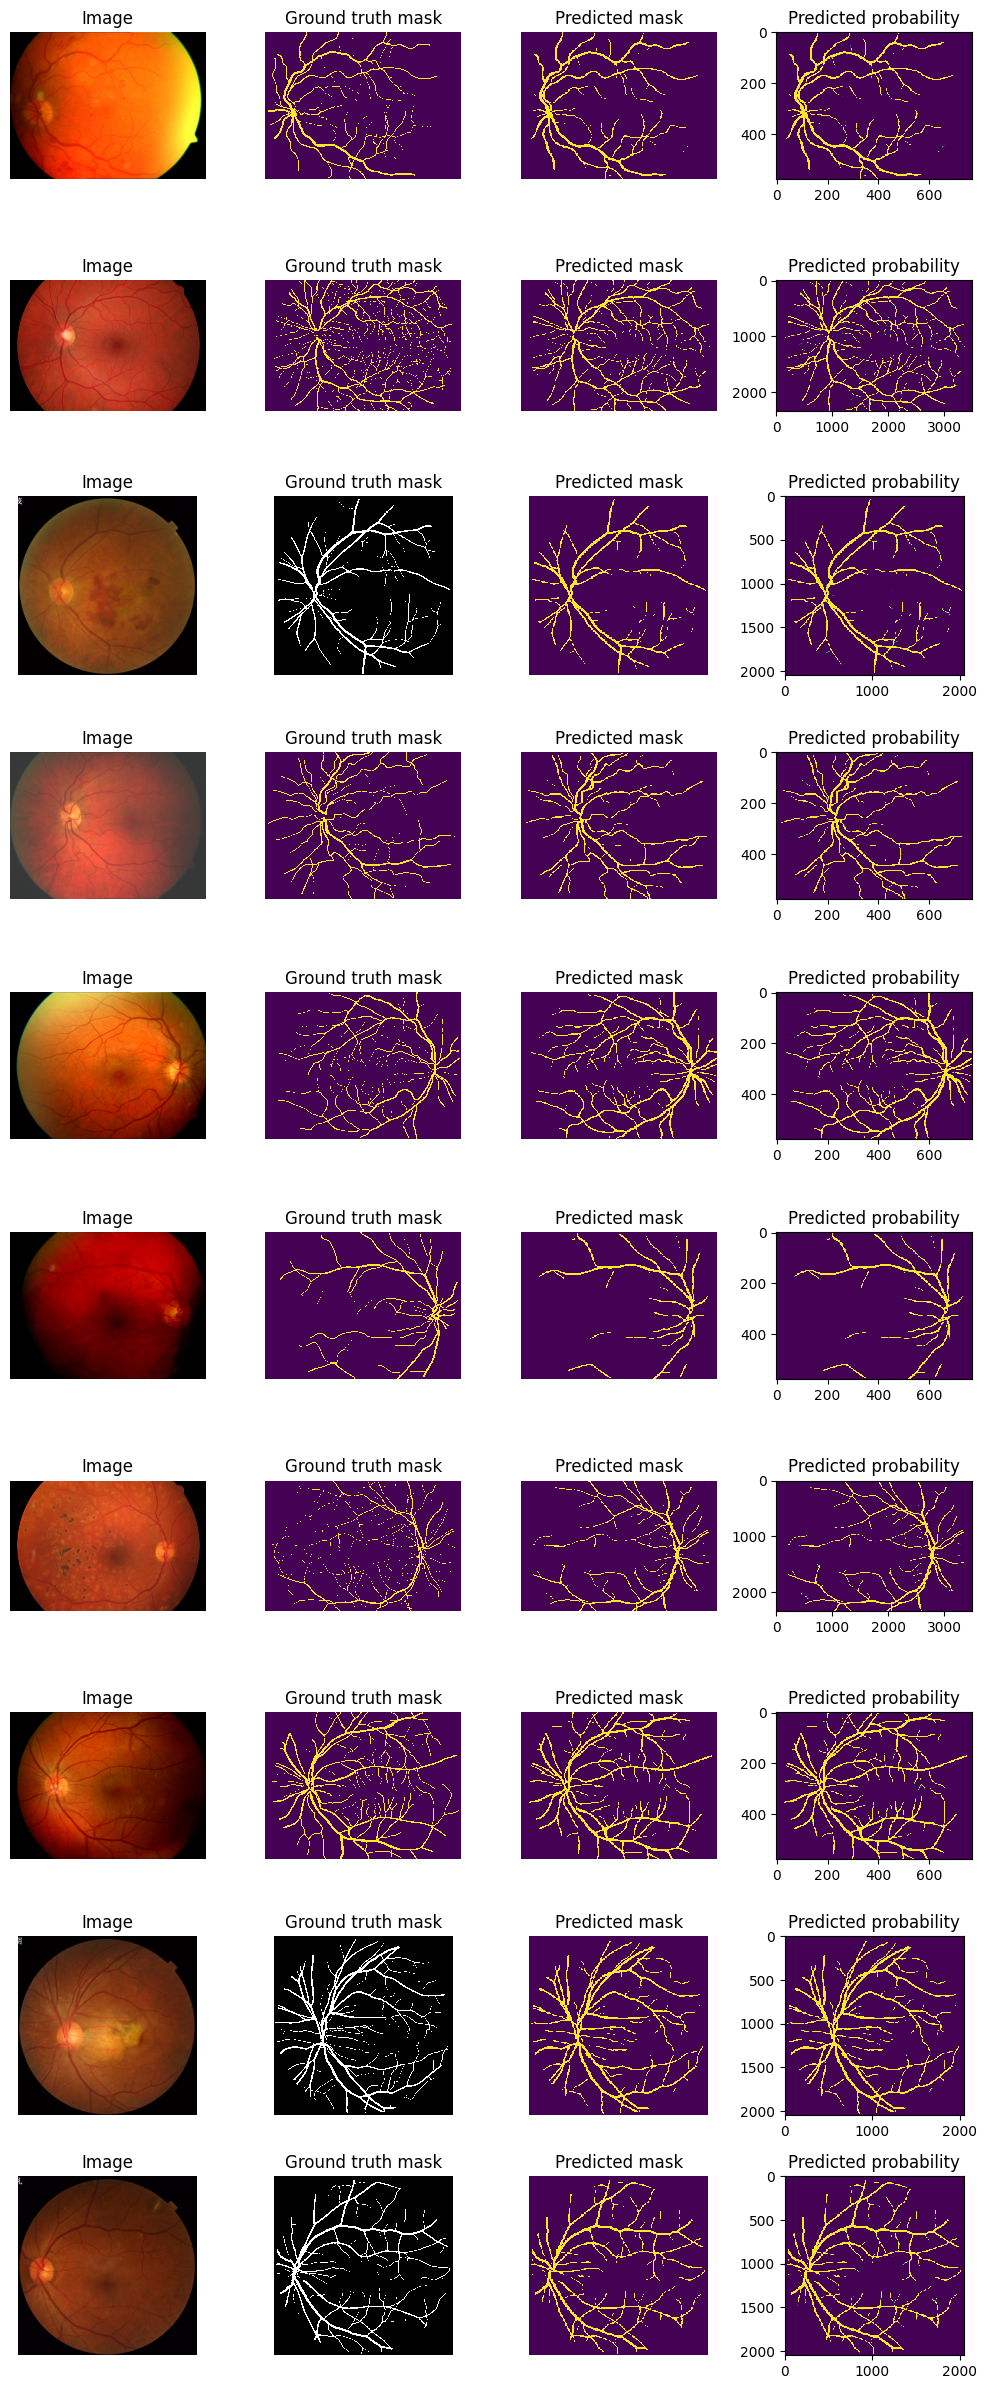

In [21]:
def paste_and_save(test_images_paths, predicted_masks, save_img):
    for i, path in enumerate(test_images_paths):
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h,w = image.shape[:2]
        image = PIL.Image.fromarray(image)

        mask_path = str(path).replace("/img\\", "/segm\\")
        if mask_path.split('\\')[-1][0] !='f' and (mask_path.split('\\')[-1].split('.')[-1] == 'jpg' or mask_path.split('\\')[-1].split('.')[-1] == 'JPG'):
            mask_path = mask_path.replace('.jpg', '.tif').replace('.JPG', '.tif')
        mask = cv2.imread(mask_path)
        mask = A.Resize(h,w)(image=mask)
        mask = PIL.Image.fromarray(mask["image"])

        predicted_mask = PIL.Image.fromarray(predicted_masks[i]*255)

        target = PIL.Image.new('RGB', (3 * w, h))
        target.paste(image, box = (0, 0))
        target.paste(mask, box = (w, 0))
        target.paste(predicted_mask, box = (2 * w, 0))
        target.save(os.path.join(save_img, 'result_{}.png'.format(path.split("\\")[-1].split('.')[0])))

paste_and_save(images_paths['test'], predicted_masks, save_img='pred_img_Unet11_jit')
display_image_grid(images_paths['test'][:10], predicted_masks=predicted_masks, predicted_probabilities=predicted_probabilities)

In [22]:
# torch.save(model.state_dict(), nm_model+'.pt')

# model = create_model(params)
# model.load_state_dict(torch.load('models/Unet11_e35_s256_b9_onlyjitter.pt'))

torch.cuda.empty_cache()